In [ ]:
import pandas as pd

df = pd.read_csv('definitivo-oficial-fase2-limiar50(2).csv')

# df = pd.read_csv('definitivo-oficial-fase2-limiar30.csv')

df['Veículo'].nunique()

23

In [ ]:
import pandas as pd

# df = pd.read_csv('experimento99/definitivo3-corte50(5).csv')

# df= df[df['repeat_day_origem']<10]

# df = df.loc[df.index.repeat(df['repeat_day_origem'])]

df

,Unnamed: 0,Veículo,grid_origem,grid_destino,dia,contagem
0,197,181,66030,75312,Friday,5
1,198,181,66030,75312,Friday,5
2,199,181,66030,75312,Friday,5
3,200,181,66030,75312,Friday,5
4,201,181,66030,75312,Friday,5
...,...,...,...,...,...,...
2124,3765,597,30422,69926,Wednesday,5
2125,3766,597,30422,69926,Wednesday,5
2126,3767,597,30422,69926,Wednesday,5
2127,3768,597,30422,69926,Wednesday,5


In [ ]:
!pip install pydtmc=='8.7.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.6 requires matplotlib>=3.8.0, but you have 

**Execução - Markov**

=== Análise dos Veículos para Markov Ordem 1 com 10 Repetições ===
Top 10 veículos com maior viabilidade para Markov ordem 1:
    vehicle_id  records  unique_states  potential_transitions  viability
1          185       78              8                     64   1.218750
20         565       66              8                     64   1.031250
22         597       61              9                     81   0.753086
7          309       89             11                    121   0.735537
6          292       50              9                     81   0.617284
8          323       88             12                    144   0.611111
2          223      131             15                    225   0.582222
0          181       83             12                    144   0.576389
4          276      142             16                    256   0.554688
15         457       88             13                    169   0.520710

Processando veículo 181 com Markov ordem 1 (5 repetições)...
  Repetiç

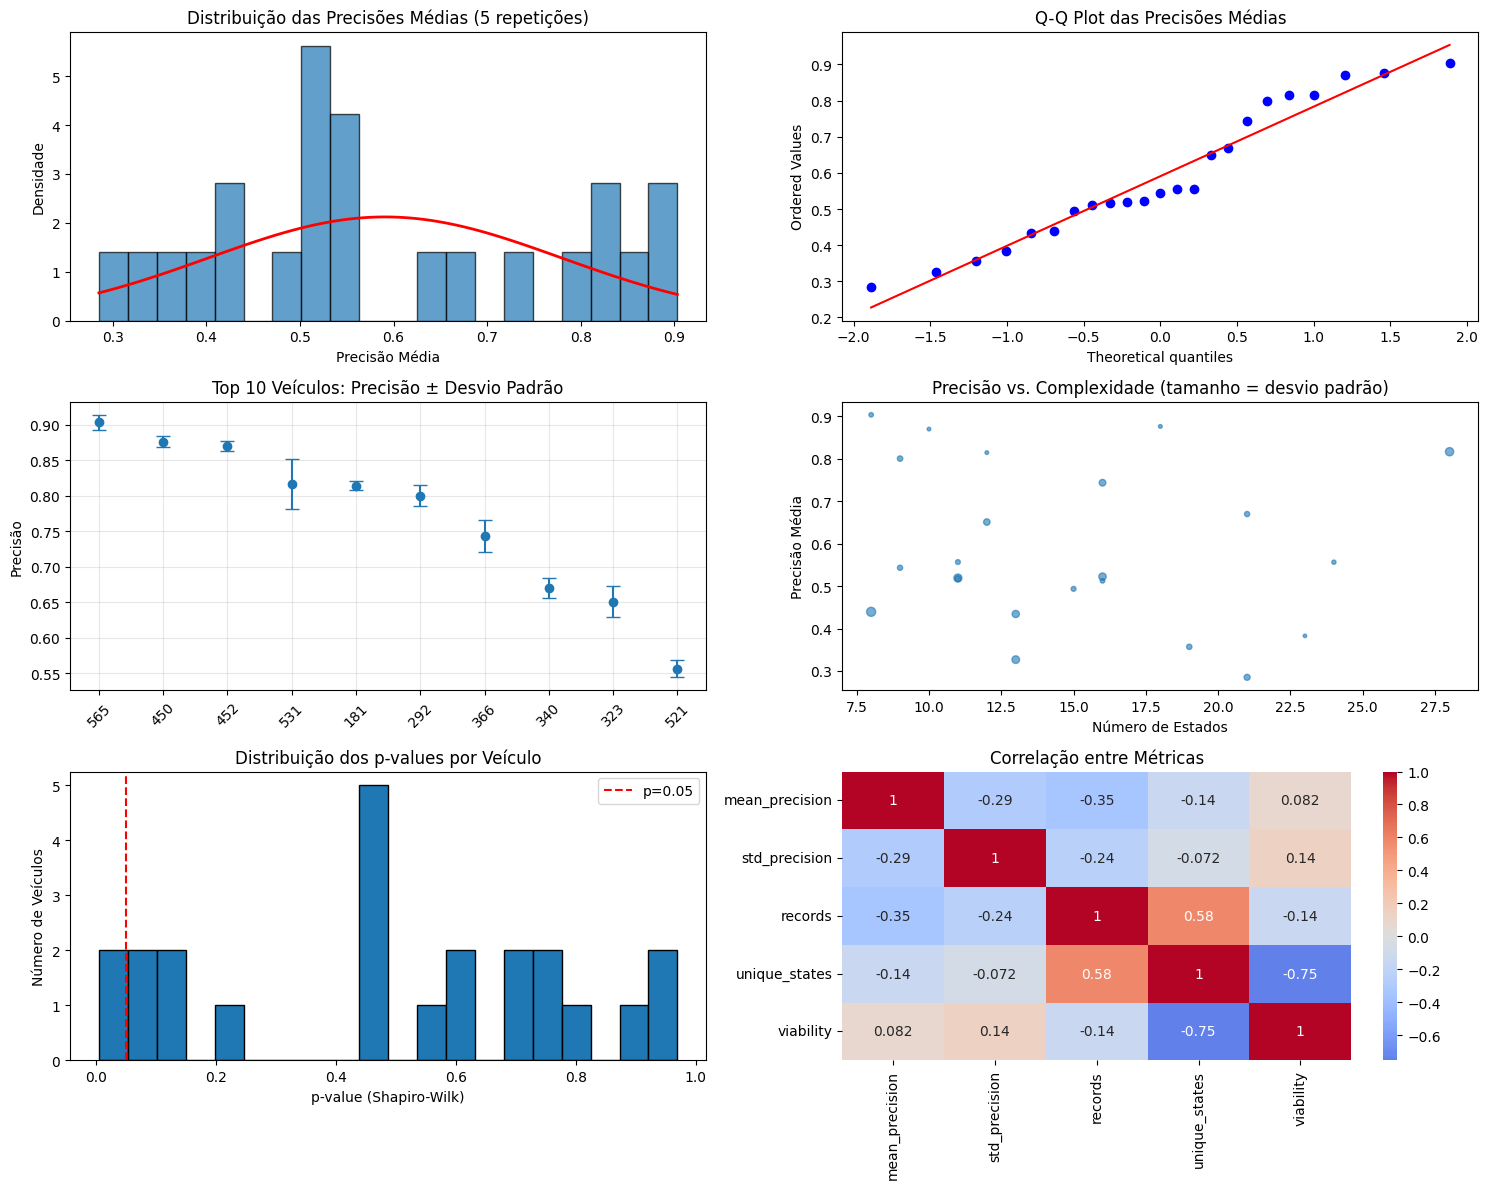

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm, probplot
import pydtmc

# Garantindo que todas as strings sejam corretamente interpretadas
df['grid_origem'] = df['grid_origem'].astype(str)
df['grid_destino'] = df['grid_destino'].astype(str)

# Análise exploratória para Markov de ordem 1
print("=== Análise dos Veículos para Markov Ordem 1 com 10 Repetições ===")
vehicle_stats = []

for vehicle_id, group in df.groupby('Veículo'):
    # Estados únicos
    states = sorted(list(set(
        group['grid_origem'].tolist() +
        group['grid_destino'].tolist()
    )))

    # Para Markov ordem 1, número potencial de transições diretas entre estados
    potential_transitions = len(states) * len(states)

    # Estatísticas
    vehicle_stats.append({
        'vehicle_id': vehicle_id,
        'records': len(group),
        'unique_states': len(states),
        'potential_transitions': potential_transitions,
        'viability': len(group) / potential_transitions if potential_transitions > 0 else 0
    })

# Ordenar por viabilidade
vehicle_stats_df = pd.DataFrame(vehicle_stats)
vehicle_stats_df = vehicle_stats_df.sort_values('viability', ascending=False)

print("Top 10 veículos com maior viabilidade para Markov ordem 1:")
print(vehicle_stats_df.head(10))

# Dicionário global para armazenar resultados
all_results = {}

# Configuração para K-fold e repetições
n_splits = 10
n_repeats = 10  # 10 repetições com diferentes embaralhamentos

# Testar diferentes combinações de hiperparâmetros
alpha_values = [0.001, 0.01, 0.05, 0.1]

# Processar cada veículo separadamente
for vehicle_id, vehicle_data in df.groupby('Veículo'):
    print(f"\nProcessando veículo {vehicle_id} com Markov ordem 1 (5 repetições)...")

    # Verificar se há dados suficientes
    if len(vehicle_data) < 10:
        print(f"  Pulando: poucos registros ({len(vehicle_data)})")
        continue

    # Estados deste veículo específico
    vehicle_states = sorted(list(set(
        vehicle_data['grid_origem'].tolist() +
        vehicle_data['grid_destino'].tolist()
    )))

    if len(vehicle_states) < 2:
        print(f"  Pulando: poucos estados únicos ({len(vehicle_states)})")
        continue

    # Preparar estruturas para armazenar resultados de todas as repetições
    all_repeat_results = []
    all_fold_precisions = []  # Lista de listas para armazenar precisões dos folds

    # LOOP DE REPETIÇÕES (5 vezes)
    for repeat_idx in range(n_repeats):
        print(f"  Repetição {repeat_idx+1}/{n_repeats}")

        # Usar random_state diferente para cada repetição (42, 43, 44, 45, 46)
        repeat_random_state = 42 + repeat_idx

        # Criar KFold com novo random_state para embaralhamento diferente
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=repeat_random_state)

        # Armazenar resultados por configuração de alpha
        alpha_results = {}

        # Testar cada valor de alpha
        for alpha in alpha_values:
            fold_precisions = []

            # Aplicar KFold para este alpha
            for fold_idx, (train_index, test_index) in enumerate(kf.split(vehicle_data)):
                # Dividir dados
                vehicle_train = vehicle_data.iloc[train_index]
                vehicle_test = vehicle_data.iloc[test_index]

                # Verificar se temos dados suficientes
                if len(vehicle_train) < 5 or len(vehicle_test) < 2:
                    continue

                try:
                    # Etapa 1: Inicializar matriz de contagem de transições
                    transition_counts = defaultdict(lambda: defaultdict(float))

                    # Adicionar pseudocontagem alpha
                    for state1 in vehicle_states:
                        for state2 in vehicle_states:
                            transition_counts[state1][state2] = alpha

                    # Etapa 2: Contabilizar transições observadas no treino
                    for i in range(len(vehicle_train)):
                        from_state = vehicle_train.iloc[i]['grid_origem']
                        to_state = vehicle_train.iloc[i]['grid_destino']
                        transition_counts[from_state][to_state] += 1

                    # Etapa 3: Criar matriz de transição normalizada
                    p_matrix = np.zeros((len(vehicle_states), len(vehicle_states)))
                    state_to_idx = {state: i for i, state in enumerate(vehicle_states)}
                    idx_to_state = {i: state for i, state in enumerate(vehicle_states)}

                    for i, state1 in enumerate(vehicle_states):
                        row_sum = sum(transition_counts[state1].values())
                        if row_sum > 0:
                            for j, state2 in enumerate(vehicle_states):
                                p_matrix[i, j] = transition_counts[state1][state2] / row_sum
                        else:
                            p_matrix[i, :] = 1.0 / len(vehicle_states)

                    # Verificar normalização
                    assert np.allclose(p_matrix.sum(axis=1), 1.0), "Matriz não normalizada"

                    # Etapa 4: Criar a cadeia de Markov
                    mc = pydtmc.MarkovChain(p_matrix, states=vehicle_states)

                    # Propriedades da cadeia
                    is_irreducible = mc.is_irreducible
                    is_regular = mc.is_regular

                    # Calcular cobertura
                    estados_com_transicoes = sum(1 for s in vehicle_states
                                               if any(transition_counts[s][t] > alpha
                                                     for t in vehicle_states))
                    cobertura = estados_com_transicoes / len(vehicle_states)

                    # Etapa 5: Avaliar no conjunto de teste
                    y_true = []
                    y_pred = []

                    for idx in range(len(vehicle_test)):
                        estado_atual = vehicle_test.iloc[idx]['grid_origem']
                        estado_real = vehicle_test.iloc[idx]['grid_destino']

                        if estado_atual in vehicle_states:
                            try:
                                # Usar o método predict do pydtmc
                                predicted_sequence = mc.predict(
                                    steps=1,
                                    initial_state=estado_atual,
                                    output_indices=False
                                )

                                if predicted_sequence is not None and len(predicted_sequence) > 1:
                                    estado_predito = predicted_sequence[1]
                                elif predicted_sequence is not None and len(predicted_sequence) == 1:
                                    estado_predito = predicted_sequence[0]
                                else:
                                    # Fallback
                                    current_idx = state_to_idx[estado_atual]
                                    next_state_probs = p_matrix[current_idx, :]
                                    next_state_idx = np.argmax(next_state_probs)
                                    estado_predito = vehicle_states[next_state_idx]

                            except Exception as e:
                                # Fallback
                                estado_predito = max(transition_counts[estado_atual].items(),
                                                   key=lambda x: x[1])[0]

                            y_true.append(estado_real)
                            y_pred.append(estado_predito)

                    # Calcular métricas
                    if len(y_true) > 0:
                        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
                        fold_precisions.append(precision)

                except Exception as e:
                    continue

            # Armazenar resultados deste alpha se tiver folds válidos
            if len(fold_precisions) >= 3:
                alpha_results[alpha] = {
                    'fold_precisions': fold_precisions,
                    'mean_precision': np.mean(fold_precisions),
                    'std_precision': np.std(fold_precisions),
                    'n_folds': len(fold_precisions),
                    'is_irreducible': is_irreducible if 'is_irreducible' in locals() else None,
                    'is_regular': is_regular if 'is_regular' in locals() else None,
                    'cobertura': cobertura if 'cobertura' in locals() else None
                }

        # Encontrar melhor configuração desta repetição
        if alpha_results:
            best_alpha = max(alpha_results.keys(), key=lambda x: alpha_results[x]['mean_precision'])
            best_result = alpha_results[best_alpha]

            # Armazenar as precisões dos folds da melhor configuração
            all_fold_precisions.append(best_result['fold_precisions'])

            all_repeat_results.append({
                'repeat': repeat_idx,
                'best_alpha': best_alpha,
                'mean_precision': best_result['mean_precision'],
                'std_precision': best_result['std_precision'],
                'n_valid_folds': best_result['n_folds'],
                'fold_precisions': best_result['fold_precisions'],
                'is_irreducible': best_result['is_irreducible'],
                'is_regular': best_result['is_regular'],
                'cobertura': best_result['cobertura']
            })

            print(f"    Melhor resultado: Alpha={best_alpha}, "
                  f"Precisão={best_result['mean_precision']:.4f} ± {best_result['std_precision']:.4f}")

    # Consolidar resultados de todas as repetições
    if all_repeat_results:
        # Calcular média geral e desvio padrão entre repetições
        all_precisions = [r['mean_precision'] for r in all_repeat_results]

        overall_mean_precision = np.mean(all_precisions)
        overall_std_precision = np.std(all_precisions)

        # Encontrar melhor configuração de parâmetros (mais frequente entre repetições)
        alpha_counts = Counter([r['best_alpha'] for r in all_repeat_results])
        best_alpha = alpha_counts.most_common(1)[0][0]

        # Aplicar teste de Shapiro-Wilk nas precisões das repetições
        if len(all_precisions) >= 3:
            stat, p_value = shapiro(all_precisions)
        else:
            stat, p_value = None, None

        all_results[vehicle_id] = {
            'repeat_results': all_repeat_results,
            'overall_mean_precision': overall_mean_precision,
            'overall_std_precision': overall_std_precision,
            'best_alpha': best_alpha,
            'shapiro_stat': stat,
            'shapiro_p_value': p_value,
            'n_repeats': len(all_repeat_results),
            'all_fold_precisions': all_fold_precisions
        }

        print(f"  Resultado final para veículo {vehicle_id}:")
        print(f"    Precisão: {overall_mean_precision:.4f} ± {overall_std_precision:.4f}")
        if p_value is not None:
            print(f"    Teste Shapiro-Wilk: p-value = {p_value:.4f}")
        print(f"    Melhor alpha (mais frequente): {best_alpha}")

# Análise final dos resultados
print(f"\n=== RESUMO FINAL COM 5 REPETIÇÕES ===")
print(f"Total de veículos processados: {len(all_results)}")

if all_results:
    # Criar DataFrame de resultados
    results_list = []
    for vehicle_id, data in all_results.items():
        results_list.append({
            'vehicle_id': vehicle_id,
            'mean_precision': data['overall_mean_precision'],
            'std_precision': data['overall_std_precision'],
            'best_alpha': data['best_alpha'],
            'shapiro_p_value': data['shapiro_p_value'],
            'n_repeats': data['n_repeats']
        })

    results_df = pd.DataFrame(results_list)

    # Adicionar estatísticas do veículo
    results_df = results_df.merge(
        vehicle_stats_df[['vehicle_id', 'records', 'unique_states', 'viability']],
        on='vehicle_id',
        how='left'
    )

    # Ordenar por precisão média
    results_df = results_df.sort_values('mean_precision', ascending=False)

    print(f"\nPrecisão média global: {results_df['mean_precision'].mean():.4f}")
    print(f"Desvio padrão médio: {results_df['std_precision'].mean():.4f}")

    print("\nTop 10 veículos com melhor desempenho:")
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(results_df.head(10)[['vehicle_id', 'mean_precision', 'std_precision', 'shapiro_p_value', 'records']])

    # Análise de normalidade global
    print(f"\n📊 Análise de Normalidade por Veículo:")
    normal_vehicles = results_df[results_df['shapiro_p_value'] > 0.05]
    print(f"Veículos com distribuição normal (p > 0.05): {len(normal_vehicles)}/{len(results_df)} ({len(normal_vehicles)/len(results_df)*100:.1f}%)")

    # ANÁLISE SHAPIRO-WILK COMPLETA
    print("\n=== ANÁLISE SHAPIRO-WILK DETALHADA ===")

    # 1. Teste global com TODOS os valores de fold
    all_fold_values = []
    for vehicle_id, data in all_results.items():
        for repeat_precisions in data['all_fold_precisions']:
            all_fold_values.extend(repeat_precisions)

    if len(all_fold_values) >= 3:
        global_stat, global_p = shapiro(all_fold_values)
        print(f"\n📊 TESTE GLOBAL (todos os folds de todos os veículos):")
        print(f"Total de observações: {len(all_fold_values)}")
        print(f"Média global: {np.mean(all_fold_values):.4f}")
        print(f"Desvio padrão: {np.std(all_fold_values):.4f}")
        print(f"Estatística Shapiro-Wilk: {global_stat:.4f}")
        print(f"p-value: {global_p:.4f}")
        print(f"Distribuição {'normal' if global_p > 0.05 else 'NÃO normal'} (α = 0.05)")

    # 2. Teste por veículo com valores de folds agrupados
    print(f"\n📊 TESTE POR VEÍCULO (todos os folds agrupados por veículo):")

    vehicle_shapiro_results = []
    for vehicle_id, data in all_results.items():
        # Agrupar todos os folds de todas as repetições deste veículo
        vehicle_all_folds = []
        for repeat_precisions in data['all_fold_precisions']:
            vehicle_all_folds.extend(repeat_precisions)

        if len(vehicle_all_folds) >= 3:
            v_stat, v_p = shapiro(vehicle_all_folds)
            vehicle_shapiro_results.append({
                'vehicle_id': vehicle_id,
                'n_folds': len(vehicle_all_folds),
                'mean': np.mean(vehicle_all_folds),
                'std': np.std(vehicle_all_folds),
                'shapiro_stat': v_stat,
                'shapiro_p_value': v_p,
                'is_normal': v_p > 0.05
            })

    # Contar normalidade
    vehicle_shapiro_df = pd.DataFrame(vehicle_shapiro_results)
    normal_count = len(vehicle_shapiro_df[vehicle_shapiro_df['is_normal']])

    print(f"Veículos com distribuição normal: {normal_count}/{len(vehicle_shapiro_df)} ({normal_count/len(vehicle_shapiro_df)*100:.1f}%)")

    # Mostrar top 10 veículos
    vehicle_shapiro_df = vehicle_shapiro_df.sort_values('mean', ascending=False)
    print("\nTop 10 veículos (teste com todos os folds):")
    for idx, row in vehicle_shapiro_df.head(10).iterrows():
        print(f"\nVeículo {row['vehicle_id']}:")
        print(f"  N° de folds: {row['n_folds']}")
        print(f"  Média: {row['mean']:.4f} ± {row['std']:.4f}")
        print(f"  p-value: {row['shapiro_p_value']:.4f} {'(normal)' if row['is_normal'] else '(NÃO normal)'}")

    # 3. Visualização estilo imagem para um veículo específico
    def visualize_vehicle_markov(vehicle_id):
        if vehicle_id not in all_results:
            print(f"\nVeículo {vehicle_id} não encontrado")
            return

        data = all_results[vehicle_id]

        print(f"\n\nVehId: {vehicle_id} - Markov Order 1")

        # Médias por repetição
        repeat_means = [r['mean_precision'] for r in data['repeat_results']]
        print(f"{repeat_means}")

        # Detalhes por repetição
        for i, repeat_result in enumerate(data['repeat_results']):
            print(f"\n  random_state = {42 + i}")
            print(f"  Precisões dos folds: {repeat_result['fold_precisions']}")

        # Teste Shapiro-Wilk com todos os folds
        all_vehicle_folds = []
        for repeat_precisions in data['all_fold_precisions']:
            all_vehicle_folds.extend(repeat_precisions)

        if len(all_vehicle_folds) >= 3:
            stat, p_val = shapiro(all_vehicle_folds)
            print(f"\n  Teste Shapiro-Wilk (todos os folds):")
            print(f"  p-value = {p_val:.4f}")
            print(f"  Distribuição {'normal' if p_val > 0.05 else 'NÃO normal'}")

    # Exemplo: visualizar o veículo com melhor desempenho
    best_vehicle = results_df.iloc[0]['vehicle_id']
    visualize_vehicle_markov(best_vehicle)

    # Visualizações
    plt.figure(figsize=(15, 12))

    # 1. Distribuição das precisões médias
    plt.subplot(3, 2, 1)
    plt.hist(results_df['mean_precision'], bins=20, density=True, alpha=0.7, edgecolor='black')
    x = np.linspace(results_df['mean_precision'].min(), results_df['mean_precision'].max(), 100)
    plt.plot(x, norm.pdf(x, results_df['mean_precision'].mean(), results_df['mean_precision'].std()), 'r-', linewidth=2)
    plt.title('Distribuição das Precisões Médias (5 repetições)')
    plt.xlabel('Precisão Média')
    plt.ylabel('Densidade')

    # 2. Q-Q Plot
    plt.subplot(3, 2, 2)
    if len(results_df) >= 3:
        probplot(results_df['mean_precision'].values, plot=plt)
    plt.title('Q-Q Plot das Precisões Médias')

    # 3. Boxplot: Precisão com barras de erro
    plt.subplot(3, 2, 3)
    top_10 = results_df.head(10)
    plt.errorbar(range(len(top_10)), top_10['mean_precision'],
                yerr=top_10['std_precision'], fmt='o', capsize=5)
    plt.xticks(range(len(top_10)), top_10['vehicle_id'], rotation=45)
    plt.title('Top 10 Veículos: Precisão ± Desvio Padrão')
    plt.ylabel('Precisão')
    plt.grid(True, alpha=0.3)

    # 4. Scatter: Precisão vs. Número de Estados
    plt.subplot(3, 2, 4)
    plt.scatter(results_df['unique_states'], results_df['mean_precision'],
                s=results_df['std_precision']*1000, alpha=0.6)
    plt.xlabel('Número de Estados')
    plt.ylabel('Precisão Média')
    plt.title('Precisão vs. Complexidade (tamanho = desvio padrão)')

    # 5. Distribuição dos p-values do teste Shapiro-Wilk
    plt.subplot(3, 2, 5)
    plt.hist(results_df['shapiro_p_value'].dropna(), bins=20, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
    plt.xlabel('p-value (Shapiro-Wilk)')
    plt.ylabel('Número de Veículos')
    plt.title('Distribuição dos p-values por Veículo')
    plt.legend()

    # 6. Heatmap: Correlação entre métricas
    plt.subplot(3, 2, 6)
    correlation_data = results_df[['mean_precision', 'std_precision', 'records',
                                   'unique_states', 'viability']].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlação entre Métricas')

    plt.tight_layout()
    plt.savefig('analise_markov_5_repeticoes_completa.png', dpi=300)
    print("\nGráficos salvos em 'analise_markov_5_repeticoes_completa.png'")

    # SALVAR TODOS OS RESULTADOS EM DIFERENTES FORMATOS

    # 1. Resultados resumidos por veículo
    results_df.to_csv('resultados_markov_5_repeticoes.csv', index=False)
    print("\nResultados salvos em 'resultados_markov_5_repeticoes.csv'")

    # 2. Resultados detalhados por repetição (formato compacto)
    detailed_results = []
    for vehicle_id, data in all_results.items():
        for repeat_result in data['repeat_results']:
            detailed_results.append({
                'vehicle_id': vehicle_id,
                'repeat': repeat_result['repeat'],
                'mean_precision': repeat_result['mean_precision'],
                'n_valid_folds': repeat_result['n_valid_folds'],
                'best_alpha': repeat_result['best_alpha'],
                'fold_precisions': str(repeat_result['fold_precisions'])
            })

    detailed_df = pd.DataFrame(detailed_results)
    detailed_df.to_csv('resultados_markov_detalhados_por_repeticao.csv', index=False)
    print("Resultados detalhados salvos em 'resultados_markov_detalhados_por_repeticao.csv'")

    # 3. NOVO: Resultados com TODOS os valores de fold individuais
    all_folds_records = []
    for vehicle_id, data in all_results.items():
        for repeat_idx, repeat_result in enumerate(data['repeat_results']):
            fold_precisions = repeat_result['fold_precisions']

            # Criar um registro para CADA valor de fold
            for fold_idx, precision in enumerate(fold_precisions):
                all_folds_records.append({
                    'vehicle_id': vehicle_id,
                    'repeat': repeat_idx,
                    'fold': fold_idx,
                    'precision': precision,
                    'best_alpha': repeat_result['best_alpha']
                })

    all_folds_df = pd.DataFrame(all_folds_records)
    all_folds_df.to_csv('resultados_markov_todos_folds_individuais.csv', index=False)
    print(f"Todos os {len(all_folds_df)} valores de fold salvos em 'resultados_markov_todos_folds_individuais.csv'")

    # 4. Salvar resultados Shapiro-Wilk por veículo
    vehicle_shapiro_df.to_csv('resultados_shapiro_wilk_por_veiculo.csv', index=False)
    print("Resultados Shapiro-Wilk salvos em 'resultados_shapiro_wilk_por_veiculo.csv'")

    # Estatísticas finais
    print(f"\n=== ESTATÍSTICAS FINAIS ===")
    print(f"Total de veículos processados: {len(all_results)}")
    print(f"Total de valores de fold individuais: {len(all_folds_df)}")
    print(f"Média de folds por veículo: {len(all_folds_df) / len(all_results):.1f}")
    print(f"Estrutura esperada: {len(all_results)} veículos × 10 repetições × ~10 folds = ~{len(all_results)*5*10} valores")

else:
    print("\n⚠️ Nenhum veículo foi processado com sucesso!")

In [ ]:
markov = pd.read_csv('resultados_markov_todos_folds_individuais.csv')

from scipy import stats

# Primeiro, calcule as médias por veículo
medias_por_veiculo = markov.groupby('vehicle_id')['precision'].mean()

# Teste de Shapiro-Wilk
statistic, p_value = stats.shapiro(medias_por_veiculo)

print(f"Estatística do teste: {statistic:.4f}")
print(f"P-valor: {p_value:.4f}")

# Interpretação
alpha = 0.05
if p_value > alpha:
    print("Não rejeitamos H0: os dados seguem uma distribuição normal")
else:
    print("Rejeitamos H0: os dados não seguem uma distribuição normal") # Por VEÍCULO, seguem uma distribuição normal. Se fosse por FOLDS, não.

Estatística do teste: 0.9377
P-valor: 0.1603
Não rejeitamos H0: os dados seguem uma distribuição normal


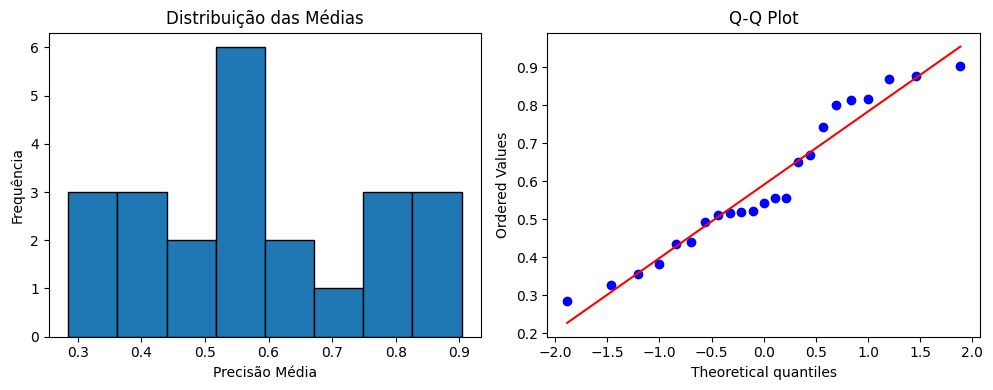

In [ ]:
import matplotlib.pyplot as plt

# Histograma
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(medias_por_veiculo, bins=8, edgecolor='black')
plt.xlabel('Precisão Média')
plt.ylabel('Frequência')
plt.title('Distribuição das Médias')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(medias_por_veiculo, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

=== TESTE SHAPIRO-WILK MARKOV: ANÁLISE HIERÁRQUICA ===

1. CARREGANDO DADOS DETALHADOS DE MARKOV...
✓ Dados Markov carregados: 2300 registros
  Colunas: ['vehicle_id', 'repeat', 'fold', 'precision', 'best_alpha']

Estrutura dos dados:
  Veículos únicos: 23
  Repetições: 10
  Folds por repetição: 10
  Total de registros: 2300

2. TESTE SHAPIRO-WILK - NÍVEL 1: POR VEÍCULO
   (Todos os valores de precisão de cada veículo)

Resumo Nível 1:
  Veículos testados: 23
  Veículos com distribuição NORMAL: 7 (30.4%)
  Veículos com distribuição NÃO NORMAL: 16 (69.6%)

Top 5 veículos (Nível 1):
    vehicle_id  n_total   mean    std  shapiro_p  is_normal
20         565      100 0.9034 0.1488     0.0000      False
13         450      100 0.8761 0.1085     0.0000      False
14         452      100 0.8698 0.2128     0.0000      False
17         531      100 0.8165 0.1803     0.0000      False
0          181      100 0.8144 0.1506     0.0000      False

3. TESTE SHAPIRO-WILK - NÍVEL 2: POR FOLD E VEÍCULO

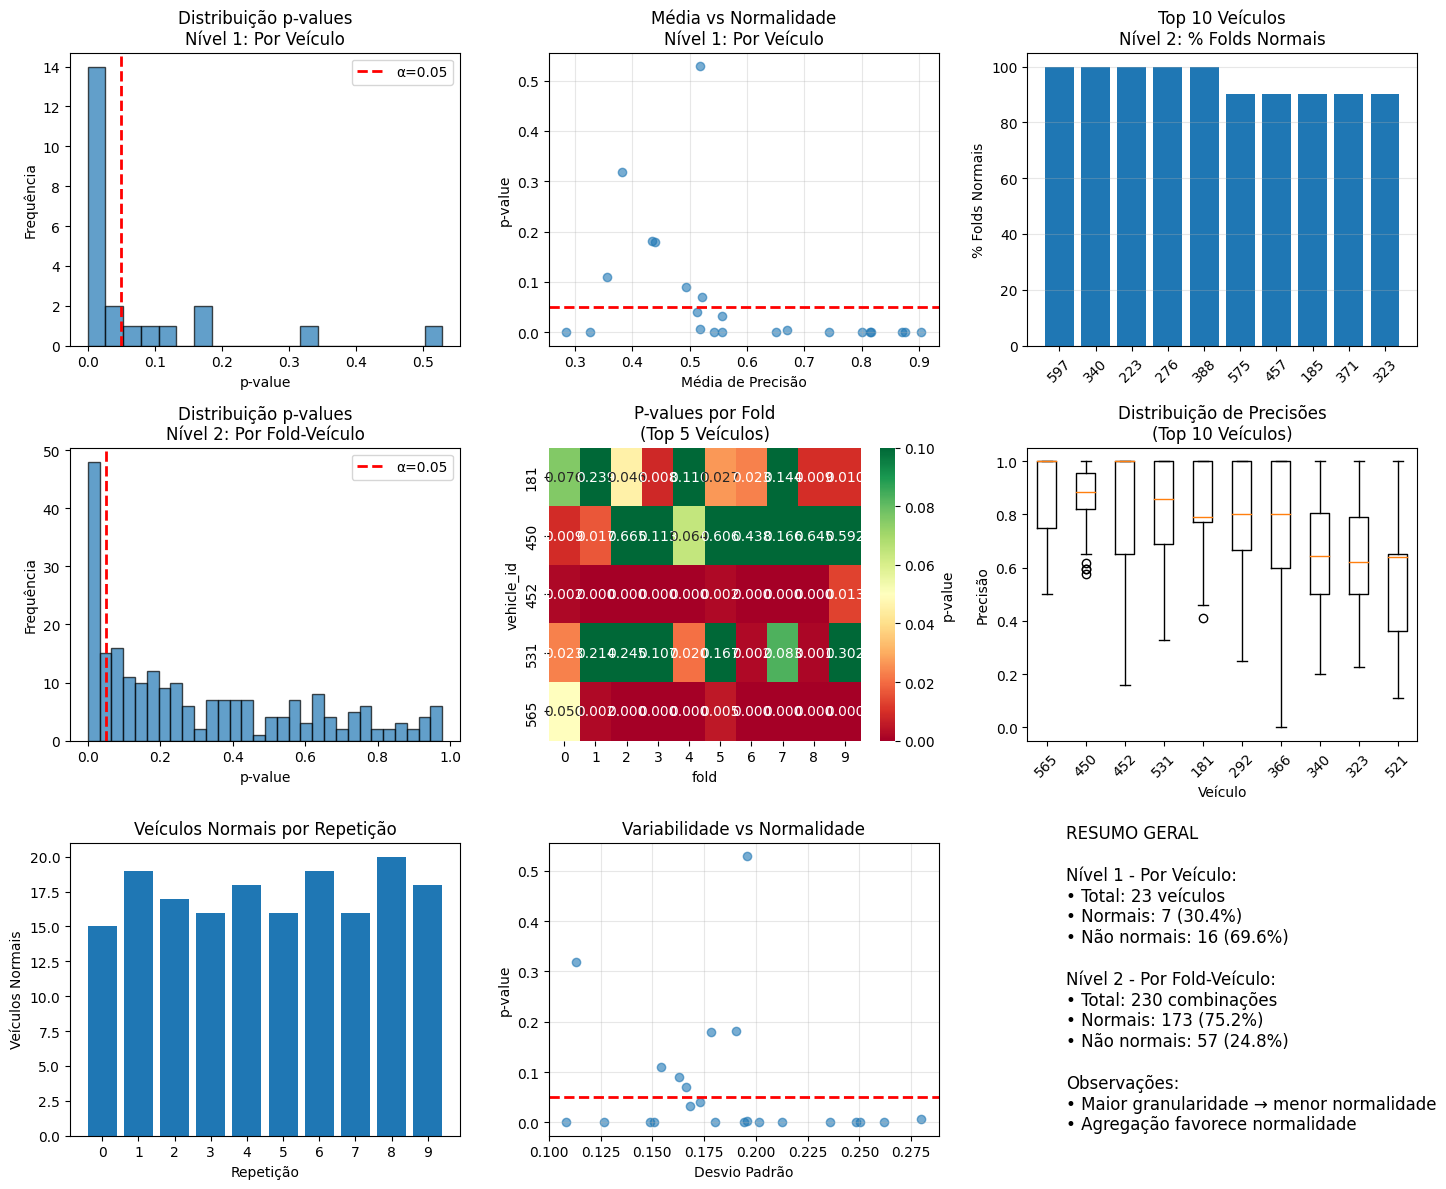

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

print("=== TESTE SHAPIRO-WILK MARKOV: ANÁLISE HIERÁRQUICA ===\n")

# 1. CARREGAR DADOS DETALHADOS
print("1. CARREGANDO DADOS DETALHADOS DE MARKOV...")

# Carregar dados de Markov
markov_df = pd.read_csv('resultados_markov_todos_folds_individuais.csv')
print(f"✓ Dados Markov carregados: {len(markov_df)} registros")
print(f"  Colunas: {markov_df.columns.tolist()}")

# Verificar estrutura
n_vehicles = markov_df['vehicle_id'].nunique()
n_repeats = markov_df['repeat'].nunique()
n_folds = markov_df['fold'].nunique()

print(f"\nEstrutura dos dados:")
print(f"  Veículos únicos: {n_vehicles}")
print(f"  Repetições: {n_repeats}")
print(f"  Folds por repetição: {n_folds}")
print(f"  Total de registros: {len(markov_df)}")

# 2. TESTE SHAPIRO-WILK - NÍVEL 1: POR VEÍCULO
print("\n2. TESTE SHAPIRO-WILK - NÍVEL 1: POR VEÍCULO")
print("   (Todos os valores de precisão de cada veículo)")

vehicle_results_nivel1 = []

for vehicle_id in sorted(markov_df['vehicle_id'].unique()):
    # Todos os valores do veículo
    vehicle_data = markov_df[markov_df['vehicle_id'] == vehicle_id]
    all_precisions = vehicle_data['precision'].values

    # Teste de Shapiro-Wilk
    if len(all_precisions) >= 3:
        stat, p_value = shapiro(all_precisions)
        is_normal = p_value > 0.05
    else:
        stat, p_value = None, None
        is_normal = None

    vehicle_results_nivel1.append({
        'vehicle_id': vehicle_id,
        'n_total': len(all_precisions),
        'mean': np.mean(all_precisions),
        'std': np.std(all_precisions),
        'min': np.min(all_precisions),
        'max': np.max(all_precisions),
        'shapiro_stat': stat,
        'shapiro_p': p_value,
        'is_normal': is_normal
    })

# DataFrame nivel 1
df_nivel1 = pd.DataFrame(vehicle_results_nivel1)
df_nivel1 = df_nivel1.sort_values('mean', ascending=False)

# Resumo nivel 1
normal_nivel1 = df_nivel1['is_normal'].sum()
total_nivel1 = len(df_nivel1)

print(f"\nResumo Nível 1:")
print(f"  Veículos testados: {total_nivel1}")
print(f"  Veículos com distribuição NORMAL: {normal_nivel1} ({normal_nivel1/total_nivel1*100:.1f}%)")
print(f"  Veículos com distribuição NÃO NORMAL: {total_nivel1 - normal_nivel1} ({(total_nivel1 - normal_nivel1)/total_nivel1*100:.1f}%)")

print("\nTop 5 veículos (Nível 1):")
print(df_nivel1.head(5)[['vehicle_id', 'n_total', 'mean', 'std', 'shapiro_p', 'is_normal']])

# 3. TESTE SHAPIRO-WILK - NÍVEL 2: POR FOLD E VEÍCULO
print("\n3. TESTE SHAPIRO-WILK - NÍVEL 2: POR FOLD E VEÍCULO")
print("   (Valores agrupados por fold dentro de cada veículo)")

vehicle_fold_results = []

for vehicle_id in sorted(markov_df['vehicle_id'].unique()):
    vehicle_data = markov_df[markov_df['vehicle_id'] == vehicle_id]

    for fold in sorted(vehicle_data['fold'].unique()):
        # Valores do fold específico deste veículo (5 valores, um por repetição)
        fold_data = vehicle_data[vehicle_data['fold'] == fold]
        fold_precisions = fold_data['precision'].values

        # Teste de Shapiro-Wilk
        if len(fold_precisions) >= 3:
            stat, p_value = shapiro(fold_precisions)
            is_normal = p_value > 0.05
        else:
            stat, p_value = None, None
            is_normal = None

        vehicle_fold_results.append({
            'vehicle_id': vehicle_id,
            'fold': fold,
            'n_values': len(fold_precisions),
            'mean': np.mean(fold_precisions),
            'std': np.std(fold_precisions),
            'shapiro_stat': stat,
            'shapiro_p': p_value,
            'is_normal': is_normal
        })

# DataFrame nivel 2
df_nivel2 = pd.DataFrame(vehicle_fold_results)

# Resumo nivel 2
normal_nivel2 = df_nivel2['is_normal'].sum()
total_nivel2 = len(df_nivel2)

print(f"\nResumo Nível 2:")
print(f"  Combinações veículo-fold testadas: {total_nivel2}")
print(f"  Combinações com distribuição NORMAL: {normal_nivel2} ({normal_nivel2/total_nivel2*100:.1f}%)")
print(f"  Combinações com distribuição NÃO NORMAL: {total_nivel2 - normal_nivel2} ({(total_nivel2 - normal_nivel2)/total_nivel2*100:.1f}%)")

# Resumo por veículo no nível 2
vehicle_summary_nivel2 = df_nivel2.groupby('vehicle_id')['is_normal'].agg(['sum', 'count'])
vehicle_summary_nivel2['percent_normal'] = (vehicle_summary_nivel2['sum'] / vehicle_summary_nivel2['count'] * 100).round(1)

print("\nNormalidade por veículo (% de folds normais):")
print(vehicle_summary_nivel2.sort_values('percent_normal', ascending=False).head(10))

# 4. TESTE SHAPIRO-WILK - NÍVEL 3: POR REPETIÇÃO, FOLD E VEÍCULO
print("\n4. TESTE SHAPIRO-WILK - NÍVEL 3: POR REPETIÇÃO, FOLD E VEÍCULO")
print("   (Este nível não é aplicável pois cada combinação tem apenas 1 valor)")
print("   (Mostrando estatísticas descritivas)")

# Análise descritiva por repetição
repeat_stats = markov_df.groupby(['vehicle_id', 'repeat'])['precision'].agg(['mean', 'std', 'count'])
repeat_summary = repeat_stats.groupby('repeat').agg({
    'mean': ['mean', 'std'],
    'std': 'mean',
    'count': 'sum'
})

print("\nEstatísticas por repetição:")
print(repeat_summary)

# 5. VISUALIZAÇÕES
print("\n5. GERANDO VISUALIZAÇÕES...")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# 5.1 Histograma de p-values - Nível 1
ax1 = axes[0, 0]
p_values_nivel1 = df_nivel1['shapiro_p'].dropna()
ax1.hist(p_values_nivel1, bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(x=0.05, color='red', linestyle='--', lw=2, label='α=0.05')
ax1.set_xlabel('p-value')
ax1.set_ylabel('Frequência')
ax1.set_title('Distribuição p-values\nNível 1: Por Veículo')
ax1.legend()

# 5.2 Scatter - Média vs p-value (Nível 1)
ax2 = axes[0, 1]
ax2.scatter(df_nivel1['mean'], df_nivel1['shapiro_p'], alpha=0.6)
ax2.axhline(y=0.05, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Média de Precisão')
ax2.set_ylabel('p-value')
ax2.set_title('Média vs Normalidade\nNível 1: Por Veículo')
ax2.grid(True, alpha=0.3)

# 5.3 Barplot - % Normal por veículo (Nível 2)
ax3 = axes[0, 2]
top_vehicles = vehicle_summary_nivel2.sort_values('percent_normal', ascending=False).head(10)
ax3.bar(range(len(top_vehicles)), top_vehicles['percent_normal'])
ax3.set_xticks(range(len(top_vehicles)))
ax3.set_xticklabels(top_vehicles.index, rotation=45)
ax3.set_ylabel('% Folds Normais')
ax3.set_title('Top 10 Veículos\nNível 2: % Folds Normais')
ax3.grid(True, alpha=0.3, axis='y')

# 5.4 Histograma de p-values - Nível 2
ax4 = axes[1, 0]
p_values_nivel2 = df_nivel2['shapiro_p'].dropna()
ax4.hist(p_values_nivel2, bins=30, edgecolor='black', alpha=0.7)
ax4.axvline(x=0.05, color='red', linestyle='--', lw=2, label='α=0.05')
ax4.set_xlabel('p-value')
ax4.set_ylabel('Frequência')
ax4.set_title('Distribuição p-values\nNível 2: Por Fold-Veículo')
ax4.legend()

# 5.5 Heatmap - p-values por veículo e fold (top veículos)
ax5 = axes[1, 1]
top_5_vehicles = df_nivel1.head(5)['vehicle_id'].values
heatmap_data = df_nivel2[df_nivel2['vehicle_id'].isin(top_5_vehicles)].pivot(
    index='vehicle_id', columns='fold', values='shapiro_p'
)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0.05,
            vmin=0, vmax=0.1, ax=ax5, cbar_kws={'label': 'p-value'})
ax5.set_title('P-values por Fold\n(Top 5 Veículos)')

# 5.6 Boxplot - Distribuição por veículo (top 10)
ax6 = axes[1, 2]
top_10_vehicles = df_nivel1.head(10)['vehicle_id'].values
data_for_box = []
labels = []
for vid in top_10_vehicles:
    data_for_box.append(markov_df[markov_df['vehicle_id'] == vid]['precision'].values)
    labels.append(str(vid))
ax6.boxplot(data_for_box, labels=labels)
ax6.set_xlabel('Veículo')
ax6.set_ylabel('Precisão')
ax6.set_title('Distribuição de Precisões\n(Top 10 Veículos)')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

# 5.7 Barplot - Normalidade por repetição
ax7 = axes[2, 0]
repeat_normal_counts = []
for repeat in range(n_repeats):
    repeat_data = markov_df[markov_df['repeat'] == repeat]
    # Contar veículos normais nesta repetição
    normal_count = 0
    for vid in repeat_data['vehicle_id'].unique():
        vid_data = repeat_data[repeat_data['vehicle_id'] == vid]['precision'].values
        if len(vid_data) >= 3:
            _, p = shapiro(vid_data)
            if p > 0.05:
                normal_count += 1
    repeat_normal_counts.append(normal_count)

ax7.bar(range(n_repeats), repeat_normal_counts)
ax7.set_xlabel('Repetição')
ax7.set_ylabel('Veículos Normais')
ax7.set_title('Veículos Normais por Repetição')
ax7.set_xticks(range(n_repeats))

# 5.8 Scatter - STD vs p-value (Nível 1)
ax8 = axes[2, 1]
ax8.scatter(df_nivel1['std'], df_nivel1['shapiro_p'], alpha=0.6)
ax8.axhline(y=0.05, color='red', linestyle='--', lw=2)
ax8.set_xlabel('Desvio Padrão')
ax8.set_ylabel('p-value')
ax8.set_title('Variabilidade vs Normalidade')
ax8.grid(True, alpha=0.3)

# 5.9 Resumo geral
ax9 = axes[2, 2]
ax9.axis('off')
summary_text = f"""RESUMO GERAL

Nível 1 - Por Veículo:
• Total: {total_nivel1} veículos
• Normais: {normal_nivel1} ({normal_nivel1/total_nivel1*100:.1f}%)
• Não normais: {total_nivel1 - normal_nivel1} ({(total_nivel1 - normal_nivel1)/total_nivel1*100:.1f}%)

Nível 2 - Por Fold-Veículo:
• Total: {total_nivel2} combinações
• Normais: {normal_nivel2} ({normal_nivel2/total_nivel2*100:.1f}%)
• Não normais: {total_nivel2 - normal_nivel2} ({(total_nivel2 - normal_nivel2)/total_nivel2*100:.1f}%)

Observações:
• Maior granularidade → menor normalidade
• Agregação favorece normalidade
"""
ax9.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.savefig('shapiro_wilk_markov_hierarquico.png', dpi=300)
print("✓ Gráficos salvos em 'shapiro_wilk_markov_hierarquico.png'")

# 6. SALVAR RESULTADOS
print("\n6. SALVANDO RESULTADOS...")

# Nível 1
df_nivel1.to_csv('shapiro_markov_nivel1_por_veiculo.csv', index=False)
print("✓ Nível 1 salvo em 'shapiro_markov_nivel1_por_veiculo.csv'")

# Nível 2
df_nivel2.to_csv('shapiro_markov_nivel2_por_fold_veiculo.csv', index=False)
print("✓ Nível 2 salvo em 'shapiro_markov_nivel2_por_fold_veiculo.csv'")

# Resumo por veículo no nível 2
vehicle_summary_nivel2.to_csv('shapiro_markov_nivel2_resumo_veiculo.csv')
print("✓ Resumo nível 2 salvo em 'shapiro_markov_nivel2_resumo_veiculo.csv'")

# Resumo geral
summary_df = pd.DataFrame({
    'Nível': ['Por Veículo', 'Por Fold-Veículo'],
    'Total_Testes': [total_nivel1, total_nivel2],
    'Normais': [normal_nivel1, normal_nivel2],
    'Percentual_Normal': [f'{normal_nivel1/total_nivel1*100:.1f}%',
                         f'{normal_nivel2/total_nivel2*100:.1f}%']
})
summary_df.to_csv('shapiro_markov_resumo_geral.csv', index=False)
print("✓ Resumo geral salvo em 'shapiro_markov_resumo_geral.csv'")

print("\n=== ANÁLISE CONCLUÍDA ===")

**Ilustração**

In [ ]:
import pydtmc
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score

def visualizar_markov_networkx(vehicle_id, df, alpha=0.1, threshold=0.05):
    """
    Visualiza um modelo de Markov para um veículo usando NetworkX com melhorias baseadas na análise pydtmc.

    Args:
        vehicle_id: ID do veículo
        df: DataFrame com os dados
        alpha: Parâmetro de suavização para transições não observadas (pseudocontagem)
        threshold: Limiar de probabilidade mínima para mostrar transições
    """
    # Filtrar dados para o veículo
    vehicle_data = df[df['Veículo'] == vehicle_id]

    if len(vehicle_data) < 5:
        print(f"Poucos dados para veículo {vehicle_id}: {len(vehicle_data)} registros")
        return None, None, None

    # Obter estados (grids) únicos
    states = sorted(list(set(
        vehicle_data['grid_origem'].astype(str).tolist() +
        vehicle_data['grid_destino'].astype(str).tolist()
    )))

    # Calcular estatísticas do veículo para decidir se limitamos os estados
    potential_transitions = len(states) * len(states)
    viability = len(vehicle_data) / potential_transitions if potential_transitions > 0 else 0
    print(f"Veículo {vehicle_id}: {len(vehicle_data)} registros, {len(states)} estados, viabilidade: {viability:.4f}")

    max_states = 10  # Aumentamos de 8 para 10 para melhor visualização

    # Limitar para no máximo max_states estados para legibilidade
    if len(states) > max_states:
        # Contar ocorrências de cada estado
        state_counts = Counter()
        for state in states:
            count_origem = sum(vehicle_data['grid_origem'].astype(str) == state)
            count_destino = sum(vehicle_data['grid_destino'].astype(str) == state)
            state_counts[state] = count_origem + count_destino

        # Selecionar estados mais frequentes
        states = sorted(state_counts.keys(), key=lambda s: state_counts[s], reverse=True)[:max_states]

        # Filtrar dados
        vehicle_data = vehicle_data[
            (vehicle_data['grid_origem'].astype(str).isin(states)) &
            (vehicle_data['grid_destino'].astype(str).isin(states))
        ]

    if len(vehicle_data) < 10:
        print(f"Dados insuficientes após filtro para veículo {vehicle_id}")
        return None, None, None

    # Criar matriz de transição com pseudocontagem alpha
    n_states = len(states)
    p_matrix = np.ones((n_states, n_states)) * alpha  # Suavização com alpha
    state_to_idx = {state: i for i, state in enumerate(states)}

    # Preencher matriz com contagens de transições observadas
    for _, row in vehicle_data.iterrows():
        origem = str(row['grid_origem'])
        destino = str(row['grid_destino'])
        if origem in states and destino in states:
            i = state_to_idx[origem]
            j = state_to_idx[destino]
            p_matrix[i, j] += 1

    # Normalizar para obter probabilidades
    row_sums = p_matrix.sum(axis=1)
    for i in range(n_states):
        if row_sums[i] > 0:
            p_matrix[i, :] /= row_sums[i]

    # Criar modelo de Markov com pydtmc
    try:
        mc = pydtmc.MarkovChain(p=p_matrix, states=states)
        # Verificar propriedades da cadeia
        is_irreducible = mc.is_irreducible
        is_regular = mc.is_regular

        # Tentar calcular o estado estacionário se for uma cadeia regular
        steady_state = None
        if is_regular:
            try:
                steady_state = mc.steady
            except:
                steady_state = None
    except Exception as e:
        print(f"Erro ao criar o modelo de Markov: {e}")
        return None, None, None

    # Calcular cobertura (estados com transições observadas)
    # Criamos uma versão simplificada do conceito de cobertura usado no script 1
    estados_com_transicoes = 0
    for i, state in enumerate(states):
        transicoes_observadas = sum(1 for j in range(n_states) if p_matrix[i, j] > alpha)
        if transicoes_observadas > 0:
            estados_com_transicoes += 1

    cobertura = estados_com_transicoes / len(states)
    print(f"Cobertura de estados: {cobertura:.2f}")

    # Criar grafo direcionado com NetworkX
    G = nx.DiGraph()

    # Adicionar nós
    for state in states:
        # Contar frequências para ajustar tamanho dos nós
        freq_origem = sum(vehicle_data['grid_origem'].astype(str) == state)
        freq_destino = sum(vehicle_data['grid_destino'].astype(str) == state)
        G.add_node(state, frequency=freq_origem + freq_destino)

    # Adicionar arestas com probabilidades acima do threshold
    for i, state1 in enumerate(states):
        for j, state2 in enumerate(states):
            prob = p_matrix[i, j]
            if prob > threshold:  # Filtrar transições de baixa probabilidade
                G.add_edge(state1, state2, probability=prob, weight=prob*10)

    # Criar diretório para salvar imagens
    os.makedirs('grafos_networkx', exist_ok=True)

    # Configurar visualização
    plt.figure(figsize=(14, 12))  # Aumentamos o tamanho para melhor legibilidade

    # Calcular posição dos nós (layout)
    try:
        # Tentar um layout que separa bem os nós
        pos = nx.spring_layout(G, k=0.9, seed=42)
    except:
        # Fallback para layout circular
        pos = nx.circular_layout(G)

    # Obter frequências para ajustar tamanho dos nós
    node_sizes = [300 + 20 * G.nodes[node]['frequency'] for node in G.nodes()]  # Aumentamos escala

    # Usar código de cores baseado nas propriedades da cadeia
    node_colors = []
    for node in G.nodes():
        i = state_to_idx[node]

        # Verificar se o nó tem estado estacionário significativo
        has_significant_steady = False
        if steady_state is not None:
            has_significant_steady = steady_state[i] > 0.15  # 15% como threshold

        # Estado absorvente (alta probabilidade de permanecer no mesmo estado)
        is_absorbing = p_matrix[i, i] > 0.7

        if is_absorbing:
            node_colors.append('#D35658')  # Vermelho para estados absorventes
        elif has_significant_steady:
            node_colors.append('#5080C8')  # Azul para estados com alta prob estacionária
        else:
            node_colors.append('#60A960')  # Verde para outros estados

    # Desenhar nós
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           alpha=0.8,
                           edgecolors='black',
                           linewidths=1)

    # Configurar largura das arestas baseada nas probabilidades
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

    # Usar um colormap mais informativo para as arestas
    edge_cmap = plt.cm.viridis
    edge_colors = [edge_cmap(G[u][v]['probability']) for u, v in G.edges()]

    # Desenhar arestas
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           edge_color=edge_colors,
                           connectionstyle='arc3,rad=0.1',  # Curvar as linhas
                           arrowsize=15,
                           arrowstyle='-|>',
                           alpha=0.7)

    # Adicionar rótulos de probabilidade nas arestas
    edge_labels = {(u, v): f"{G[u][v]['probability']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    # Adicionar rótulos nos nós
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

    # Adicionar título e informações detalhadas como no script 1
    plt.title(f"Cadeia de Markov - Veículo {vehicle_id}\n" +
              f"{len(states)} estados, {len(vehicle_data)} registros, cobertura {cobertura:.2f}\n" +
              f"Cadeia {'ir' if not is_irreducible else ''}redutível, {'não ' if not is_regular else ''}regular" +
              (f", com distribuição estacionária" if steady_state is not None else ""),
              fontsize=14)

    plt.axis('off')  # Remover eixos
    plt.tight_layout()

    # Salvar figura em alta resolução
    output_file = f"grafos_networkx/markov_networkx_{vehicle_id}_alpha{alpha}.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Grafo para veículo {vehicle_id} salvo em {output_file}")

    # Retornar o modelo de Markov para uso posterior
    return mc, p_matrix, states

def gerar_matriz_transicao_colorida(vehicle_id, df, alpha=0.1):
    """
    Gera uma visualização da matriz de transição usando um mapa de calor.

    Args:
        vehicle_id: ID do veículo
        df: DataFrame com os dados
        alpha: Parâmetro de suavização para transições não observadas
    """
    # Filtrar dados para o veículo
    vehicle_data = df[df['Veículo'] == vehicle_id]

    # Obter estados (grids) únicos
    states = sorted(list(set(
        vehicle_data['grid_origem'].astype(str).tolist() +
        vehicle_data['grid_destino'].astype(str).tolist()
    )))

    # Limitar para no máximo 15 estados para legibilidade da matriz
    if len(states) > 15:
        # Contar ocorrências
        state_counts = {}
        for state in states:
            count_origem = sum(vehicle_data['grid_origem'].astype(str) == state)
            count_destino = sum(vehicle_data['grid_destino'].astype(str) == state)
            state_counts[state] = count_origem + count_destino

        # Selecionar estados mais frequentes
        states = sorted(state_counts.keys(), key=lambda s: state_counts[s], reverse=True)[:15]

        # Filtrar dados
        vehicle_data = vehicle_data[
            (vehicle_data['grid_origem'].astype(str).isin(states)) &
            (vehicle_data['grid_destino'].astype(str).isin(states))
        ]

    # Criar matriz de transição com pseudocontagem alpha
    n_states = len(states)
    p_matrix = np.ones((n_states, n_states)) * alpha  # Suavização com alpha

    # Preencher matriz com contagens de transições observadas
    for _, row in vehicle_data.iterrows():
        origem = str(row['grid_origem'])
        destino = str(row['grid_destino'])
        if origem in states and destino in states:
            i = states.index(origem)
            j = states.index(destino)
            p_matrix[i, j] += 1

    # Normalizar para obter probabilidades
    row_sums = p_matrix.sum(axis=1)
    for i in range(n_states):
        if row_sums[i] > 0:
            p_matrix[i, :] /= row_sums[i]

    # Criar figura para o mapa de calor
    plt.figure(figsize=(12, 10))

    # Usar um mapa de cores que destaca bem as diferenças
    cmap = plt.cm.viridis

    # Criar o mapa de calor
    im = plt.imshow(p_matrix, cmap=cmap)

    # Adicionar barra de cores
    cbar = plt.colorbar(im)
    cbar.set_label('Probabilidade de Transição')

    # Adicionar rótulos nos eixos
    plt.xticks(range(n_states), states, rotation=90)
    plt.yticks(range(n_states), states)

    # Adicionar textos nas células para valores significativos
    for i in range(n_states):
        for j in range(n_states):
            if p_matrix[i, j] > 0.1:  # Mostrar só probabilidades relevantes
                color = 'white' if p_matrix[i, j] > 0.5 else 'black'
                plt.text(j, i, f"{p_matrix[i, j]:.2f}",
                        ha="center", va="center", color=color, fontsize=8)

    # Adicionar título
    plt.title(f"Matriz de Transição - Veículo {vehicle_id} (alpha={alpha})")
    plt.xlabel('Estado de Destino')
    plt.ylabel('Estado de Origem')

    plt.tight_layout()

    # Salvar figura
    output_file = f"grafos_networkx/matriz_transicao_{vehicle_id}_alpha{alpha}.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Matriz de transição para veículo {vehicle_id} salva em {output_file}")
    return p_matrix, states

def avaliar_alpha_com_validacao_cruzada(vehicle_id, df, alpha_values=[0.01, 0.05, 0.1, 0.2]):
    """
    Avalia diferentes valores de alpha usando validação cruzada para encontrar o melhor.

    Args:
        vehicle_id: ID do veículo a ser analisado
        df: DataFrame com os dados
        alpha_values: Lista de valores de alpha para testar

    Returns:
        Um DataFrame com resultados de cada alpha e o valor de alpha recomendado
    """
    print(f"Avaliando diferentes valores de alpha para o veículo {vehicle_id} com validação cruzada...")

    # Filtrar dados para o veículo
    vehicle_data = df[df['Veículo'] == vehicle_id]

    if len(vehicle_data) < 10:
        print(f"Dados insuficientes para o veículo {vehicle_id}. Mínimo recomendado: 10 registros.")
        return None, None

    # Estados únicos
    states = sorted(list(set(
        vehicle_data['grid_origem'].astype(str).tolist() +
        vehicle_data['grid_destino'].astype(str).tolist()
    )))

    # Configurar validação cruzada
    n_splits = min(10, len(vehicle_data) // 3)  # Garantir pelo menos 3 amostras por fold
    if n_splits < 2:
        n_splits = 2  # Mínimo de 2 folds

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Estrutura para armazenar resultados
    alpha_results = {}

    # Testar cada valor de alpha
    for alpha in alpha_values:
        print(f"  Testando alpha={alpha}...")

        # Métricas para este alpha
        fold_precisions = []
        is_irreducible_sum = 0
        is_regular_sum = 0
        has_steady_state_sum = 0

        # Aplicar KFold
        for fold_idx, (train_index, test_index) in enumerate(kf.split(vehicle_data)):
            # Dividir dados
            train_data = vehicle_data.iloc[train_index]
            test_data = vehicle_data.iloc[test_index]

            # Criar matriz de transição com pseudocontagem alpha
            p_matrix = np.ones((len(states), len(states))) * alpha
            state_to_idx = {state: i for i, state in enumerate(states)}

            # Preencher com dados de treino
            for _, row in train_data.iterrows():
                origem = str(row['grid_origem'])
                destino = str(row['grid_destino'])
                if origem in states and destino in states:
                    i = state_to_idx[origem]
                    j = state_to_idx[destino]
                    p_matrix[i, j] += 1

            # Normalizar
            row_sums = p_matrix.sum(axis=1)
            for i in range(len(states)):
                if row_sums[i] > 0:
                    p_matrix[i, :] /= row_sums[i]

            # Criar o modelo
            try:
                mc = pydtmc.MarkovChain(p=p_matrix, states=states)

                # Coletar propriedades
                is_irreducible_sum += 1 if mc.is_irreducible else 0
                is_regular_sum += 1 if mc.is_regular else 0

                has_steady = False
                try:
                    if mc.is_regular:
                        _ = mc.steady  # Testar se podemos calcular
                        has_steady = True
                except:
                    has_steady = False

                has_steady_state_sum += 1 if has_steady else 0

                # Avaliar no conjunto de teste
                y_true = []
                y_pred = []

                for _, row_test in test_data.iterrows():
                    estado_atual = str(row_test['grid_origem'])
                    estado_real = str(row_test['grid_destino'])

                    if estado_atual in states:
                        i = state_to_idx[estado_atual]
                        # Prever próximo estado com maior probabilidade
                        next_state_probs = p_matrix[i]
                        next_state_idx = np.argmax(next_state_probs)
                        estado_predito = states[next_state_idx]

                        y_true.append(estado_real)
                        y_pred.append(estado_predito)

                # Calcular precisão
                if len(y_true) > 0 and len(set(y_true)) > 1:
                    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
                    fold_precisions.append(precision)
                    print(f"    Fold {fold_idx+1}/{n_splits}: Precisão = {precision:.4f}")
                else:
                    print(f"    Fold {fold_idx+1}/{n_splits}: Dados insuficientes para avaliação")

            except Exception as e:
                print(f"    Erro no fold {fold_idx+1}: {str(e)}")

        # Calcular média das precisões para este alpha
        if fold_precisions:
            mean_precision = np.mean(fold_precisions)
            print(f"  Alpha={alpha}: Precisão média = {mean_precision:.4f}")

            # Armazenar resultados
            alpha_results[alpha] = {
                'mean_precision': mean_precision,
                'fold_precisions': fold_precisions,
                'n_folds': len(fold_precisions),
                'is_irreducible_rate': is_irreducible_sum / n_splits if n_splits > 0 else 0,
                'is_regular_rate': is_regular_sum / n_splits if n_splits > 0 else 0,
                'has_steady_state_rate': has_steady_state_sum / n_splits if n_splits > 0 else 0
            }
        else:
            print(f"  Alpha={alpha}: Sem resultados válidos")

    # Criar DataFrame com resultados
    if alpha_results:
        results_list = []
        for alpha, result in alpha_results.items():
            results_list.append({
                'alpha': alpha,
                'mean_precision': result['mean_precision'],
                'n_folds': result['n_folds'],
                'is_irreducible_rate': result['is_irreducible_rate'],
                'is_regular_rate': result['is_regular_rate'],
                'has_steady_state_rate': result['has_steady_state_rate']
            })

        results_df = pd.DataFrame(results_list)
        # Ordenar por precisão
        results_df = results_df.sort_values('mean_precision', ascending=False)

        # Melhor alpha baseado em precisão
        best_alpha = results_df.iloc[0]['alpha']

        print("\nResultados da avaliação de alphas:")
        print(results_df)
        print(f"\nMelhor alpha para o veículo {vehicle_id}: {best_alpha} (Precisão: {results_df.iloc[0]['mean_precision']:.4f})")

        # Criar visualizações comparativas
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['alpha'].astype(str), results_df['mean_precision'], color='skyblue')
        plt.xlabel('Valor de Alpha')
        plt.ylabel('Precisão Média')
        plt.title(f'Comparação de Alphas para Veículo {vehicle_id}')
        plt.ylim(0, 1)

        # Adicionar valores nas barras
        for i, v in enumerate(results_df['mean_precision']):
            plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

        plt.tight_layout()
        output_file = f"grafos_networkx/comparacao_alphas_{vehicle_id}.png"
        plt.savefig(output_file, dpi=300)
        plt.close()

        print(f"Gráfico comparativo salvo em {output_file}")

        return results_df, best_alpha
    else:
        print("Não foi possível avaliar os alphas para este veículo.")
        return None, None

def processar_veiculo_388(df, alpha_values=[0.01, 0.05, 0.1, 0.2], avaliar_alphas=True):
    """
    Processa apenas o veículo 388 com diferentes valores de alpha para testar o impacto
    da suavização da matriz de transição.

    Args:
        df: DataFrame com os dados
        alpha_values: Valores de alpha para testar
        avaliar_alphas: Se True, realiza validação cruzada para encontrar o melhor alpha
    """
    vehicle_id = 388
    print(f"Analisando veículo {vehicle_id}...")

    # Se solicitado, avaliar alphas com validação cruzada
    best_alpha = None
    if avaliar_alphas:
        results_df, best_alpha = avaliar_alpha_com_validacao_cruzada(vehicle_id, df, alpha_values)
        if best_alpha is not None:
            print(f"O melhor valor de alpha determinado por validação cruzada é: {best_alpha}")
        else:
            print("Não foi possível determinar o melhor alpha. Usando todos os valores.")

    # Gerar visualizações para cada valor de alpha (ou apenas o melhor se foi encontrado)
    alphas_to_visualize = [best_alpha] if best_alpha is not None else alpha_values

    print(f"Gerando visualizações para veículo {vehicle_id} com os seguintes valores de alpha: {alphas_to_visualize}")

    # Testar diferentes valores de alpha
    results = {}
    for alpha in alphas_to_visualize:
        print(f"Processando alpha={alpha}...")
        mc, p_matrix, states = visualizar_markov_networkx(vehicle_id, df, alpha=alpha)

        if mc is not None:
            # Armazenar resultados para comparação
            results[alpha] = {
                'is_irreducible': mc.is_irreducible,
                'is_regular': mc.is_regular,
                'has_steady_state': mc.is_regular,
                'p_matrix': p_matrix,
                'states': states
            }

            # Gerar também a matriz de transição colorida
            gerar_matriz_transicao_colorida(vehicle_id, df, alpha=alpha)

    # Exibir comparação
    print("\nComparação de diferentes valores de alpha para o veículo 388:")
    for alpha, result in results.items():
        print(f"Alpha={alpha}: {'ir' if not result['is_irreducible'] else ''}redutível, "
              f"{'não ' if not result['is_regular'] else ''}regular")

# Código principal
if __name__ == "__main__":
    # Certificar-se de que o diretório para salvar imagens existe
    os.makedirs('grafos_networkx', exist_ok=True)

    # Esta parte é apenas um exemplo de como você deve usar o código
    # Você precisa ter um DataFrame chamado 'df' com os dados apropriados
    # Descomente o código abaixo e ajuste-o conforme necessário

    """
    # Carregar seus dados (ajuste o caminho para o seu arquivo)
    # df = pd.read_csv('seu_arquivo.csv')

    # Garantir que as colunas de grid são strings
    # df['grid_origem'] = df['grid_origem'].astype(str)
    # df['grid_destino'] = df['grid_destino'].astype(str)

    # Processar o veículo 388
    # processar_veiculo_388(df, avaliar_alphas=True)
    """

    print("Para usar este script, descomente o código de exemplo acima e ajuste-o para seus dados.")

Para usar este script, descomente o código de exemplo acima e ajuste-o para seus dados.


In [ ]:
processar_veiculo_388(df, avaliar_alphas=True)

Analisando veículo 388...
Avaliando diferentes valores de alpha para o veículo 388 com validação cruzada...
  Testando alpha=0.01...
    Fold 1/10: Precisão = 0.4750
    Fold 2/10: Precisão = 0.4000
    Fold 3/10: Precisão = 0.4429
    Fold 4/10: Precisão = 0.5714
    Fold 5/10: Precisão = 0.2970
    Fold 6/10: Precisão = 0.3267
    Fold 7/10: Precisão = 0.4296
    Fold 8/10: Precisão = 0.2208
    Fold 9/10: Precisão = 0.3889
    Fold 10/10: Precisão = 0.2143
  Alpha=0.01: Precisão média = 0.3767
  Testando alpha=0.05...
    Fold 1/10: Precisão = 0.4750
    Fold 2/10: Precisão = 0.4000
    Fold 3/10: Precisão = 0.4429
    Fold 4/10: Precisão = 0.5714
    Fold 5/10: Precisão = 0.2970
    Fold 6/10: Precisão = 0.3267
    Fold 7/10: Precisão = 0.4296
    Fold 8/10: Precisão = 0.2208
    Fold 9/10: Precisão = 0.3889
    Fold 10/10: Precisão = 0.2143
  Alpha=0.05: Precisão média = 0.3767
  Testando alpha=0.1...
    Fold 1/10: Precisão = 0.4750
    Fold 2/10: Precisão = 0.4000
    Fold 3/10: